Segmentation (or clustering) is a well known technique for categorizing unlabelled data and has been used in unsupervised learning. It helps with the creation of classes for the provided data. For this project I try to predict the right cluster for the customers of an automobile company. 

This dataset has been taken by kaggle: https://www.kaggle.com/datasets/vetrirah/customer?select=Train.csv
Specifically, one can also see the case at: https://datahack.analyticsvidhya.com/contest/janatahack-customer-segmentation/#ProblemStatement


**Working Scenario:**

An automobile company has plans to enter new markets with their existing products. After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market.

In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers.

The job in this notebook is to understand the dataset and predict the right group of the new customers.

#### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Read the data

In [2]:
data = pd.read_csv("data.csv")
data.head()

ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
0  462809    Male           No   22        No     Healthcare              1.0   
1  462643  Female          Yes   38       Yes       Engineer              NaN   
2  466315  Female          Yes   67       Yes       Engineer              1.0   
3  461735    Male          Yes   67       Yes         Lawyer              0.0   
4  462669  Female          Yes   40       Yes  Entertainment              NaN   

  Spending_Score  Family_Size  Var_1 Segmentation  
0            Low          4.0  Cat_4            D  
1        Average          3.0  Cat_4            A  
2            Low          1.0  Cat_6            B  
3           High          2.0  Cat_6            B  
4           High          6.0  Cat_6            A

In [3]:
data.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

#### Columns explanation

Before I go on, let's see what is the meaning of each column:

- **ID** : Customer's identity
- **Gender**: Customer's sex
- **Ever_Married**: Whether the customer has ever been married
- **Age**: Customer's age
- **Graduated**: Whether the customer has graduated or not
- **Profession**: The working field of the customer
- **Work_Experience**: How many years of working experience does the customer have?
- **Spending_Score**: How much does the customer spend? (It must internal categorization)
- **Family Size**: How big is the customer's family?
- **Var_1**: Variable with no title...
- **Segmentation**: Initial segmentation

# Data Cleaning

In [4]:
for x in data.columns:
    print(x, ":", data[x].isna().sum())

ID : 0
Gender : 0
Ever_Married : 140
Age : 0
Graduated : 78
Profession : 124
Work_Experience : 829
Spending_Score : 0
Family_Size : 335
Var_1 : 76
Segmentation : 0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


<AxesSubplot:>

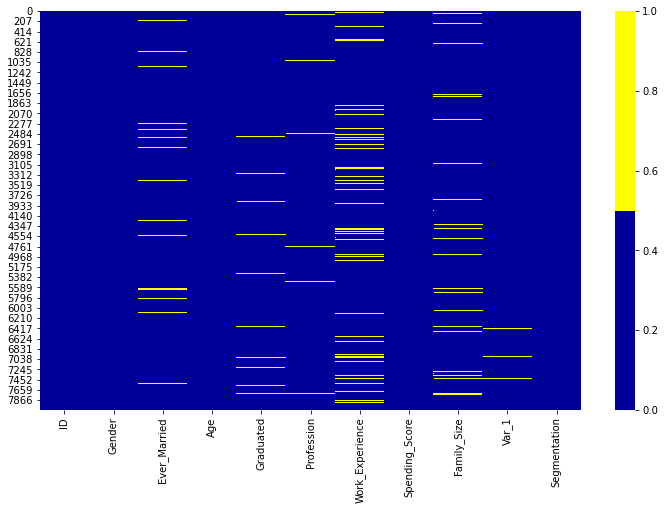

In [6]:
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.

fig, ax = plt.subplots(1,1,figsize=(14,10))
fig.tight_layout(pad=15.0)

cols_x = data.columns
cols_y = data.columns
sns.heatmap(data[cols_x].isnull(), ax=ax, cmap=sns.color_palette(colours))

A lot of data are missing...

One way to overcome this problem is to use a combination of the different techniques that are provided by the impute class of scikit-learn:
- SimpleImputer
- IterativeImputer
- MissingIndicator
- KNNImputer

However, I drop the nan values and continue...

### Drop the Nan values

In [7]:
data_cl = data.copy()
data_cl.dropna(inplace=True)
data_cl.reset_index(inplace=True)
data_cl = data_cl.drop("index", axis=1)

### Check duplicated values

In [8]:
data_cl.duplicated().sum()

0

There are no duplicated values.

Do I need the ID column? The answer is No!

In [9]:
data_cl = data_cl.drop("ID", axis=1)
data_cl.head(5)

Gender Ever_Married  Age Graduated  Profession  Work_Experience  \
0    Male           No   22        No  Healthcare              1.0   
1  Female          Yes   67       Yes    Engineer              1.0   
2    Male          Yes   67       Yes      Lawyer              0.0   
3    Male          Yes   56        No      Artist              0.0   
4    Male           No   32       Yes  Healthcare              1.0   

  Spending_Score  Family_Size  Var_1 Segmentation  
0            Low          4.0  Cat_4            D  
1            Low          1.0  Cat_6            B  
2           High          2.0  Cat_6            B  
3        Average          2.0  Cat_6            C  
4            Low          3.0  Cat_6            C

### Find continuous and categorical columns

In [10]:
continuous_columns, categorical_columns = [], []
for x in data_cl.columns:
    if data_cl[x].dtypes=='object':
        categorical_columns.append(x)
    else:
        continuous_columns.append(x)

# Data Analysis

In this part I want to understand the dataset.

/Users/antonis1991/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


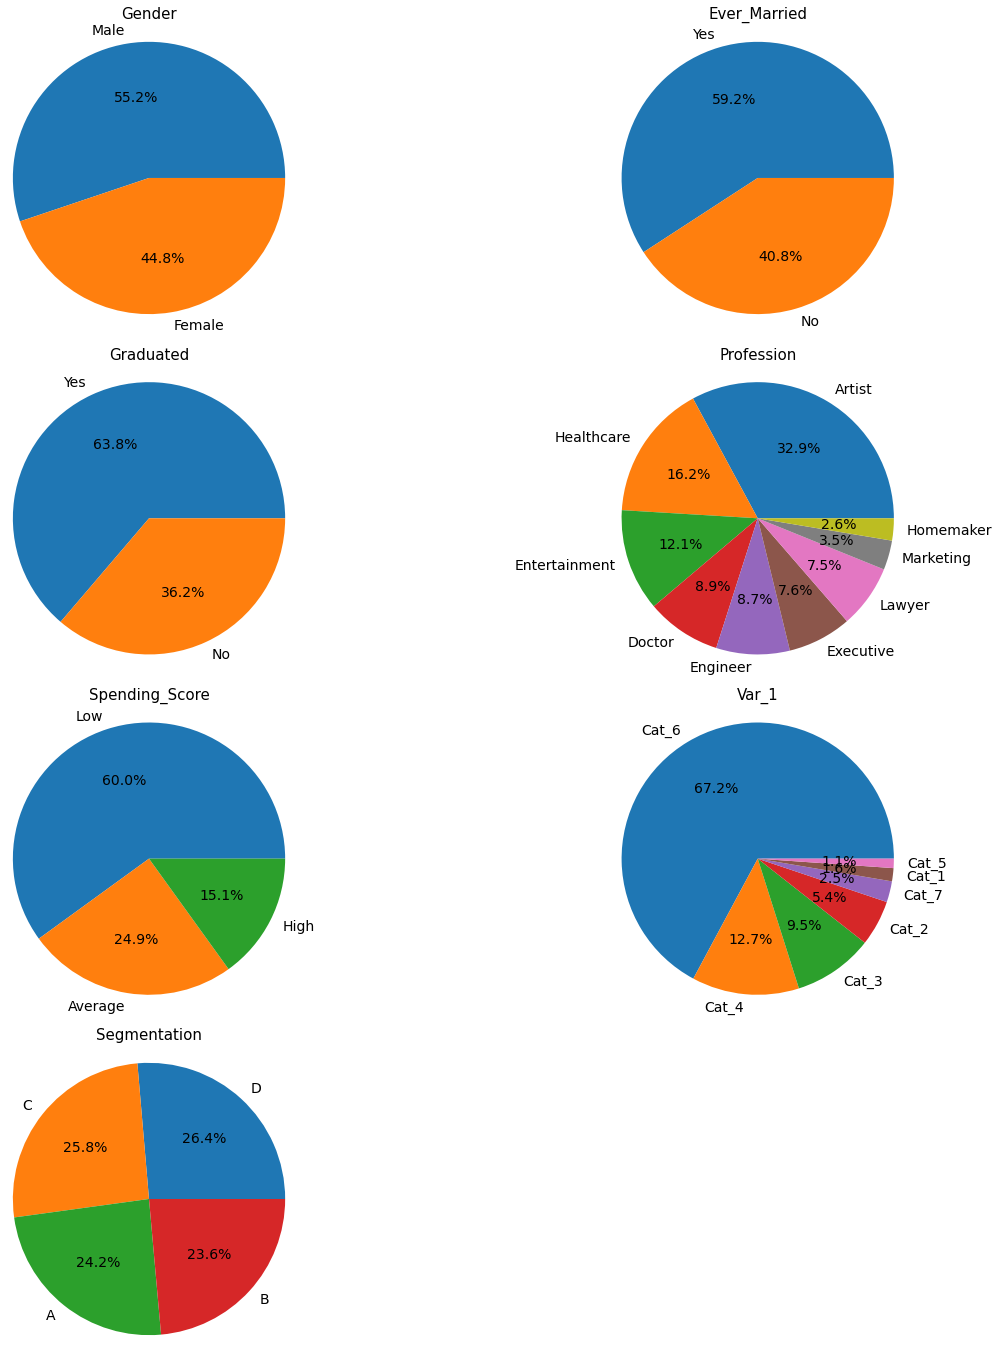

In [11]:
fig, ax = plt.subplots(4,2,figsize=(20,24))
ax = ax.flatten()
fig.delaxes(ax[-1])

for i,x in enumerate(categorical_columns):
    (data_cl[x].value_counts()/data_cl[x].value_counts().sum()).plot.pie(autopct='%1.1f%%', 
                                                                         fontsize=14, ax=ax[i], radius=1.2)
    ax[i].set_title(x, y=1.04, fontsize=15)
    ax[i].set_ylabel("")

The pie charts show the percentages of the different categories per feature. Three interesting outcomes:
- 60% of the data say that customers are spending low,
- Cat_6 of the undefined feature has almost 70% of the dataset, and
- The initial segments are almost balanced, around 25% each of them.

### Let's see the pairplot for the continuous features

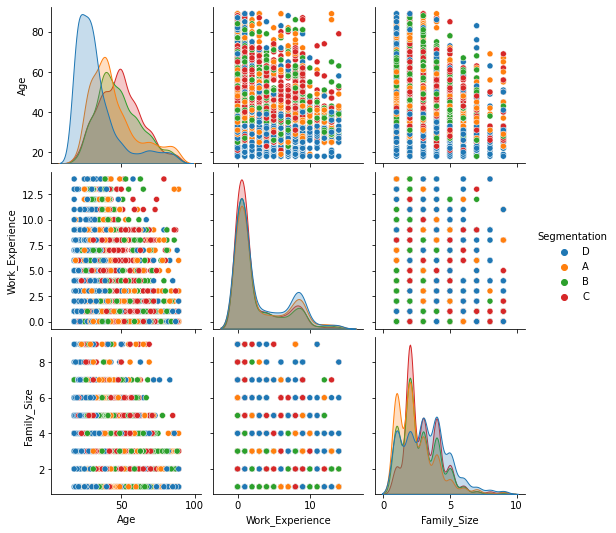

In [12]:
sns.pairplot(data=data[continuous_columns + ['Segmentation']], hue='Segmentation')

Let's see specifically the continuous features.

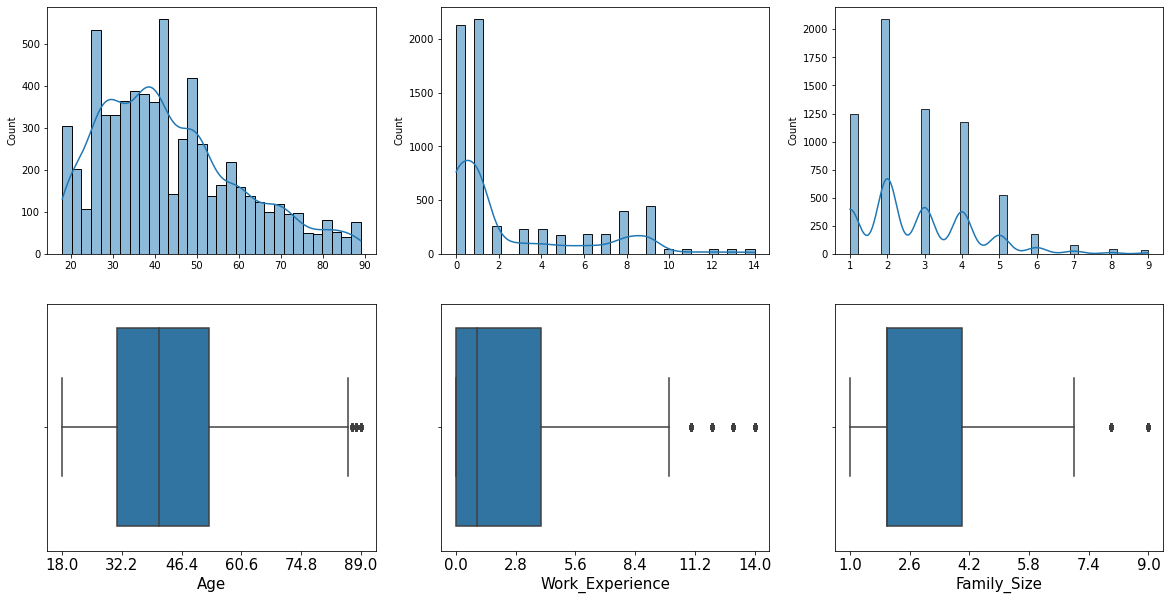

In [13]:
specific_col = ["Age","Work_Experience","Family_Size"]

fig, ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.flatten()

for i,plot in enumerate(specific_col):
    sns.histplot(data=data_cl, x=plot, ax=ax[i], kde=True)
    ax[i].set_xlabel("")
    
for i,plot in enumerate(specific_col):
    sns.boxplot(data=data_cl, x=plot, ax=ax[i+3])
    ax[i+3].set_xticks(np.around(np.linspace(data_cl[plot].min(), data_cl[plot].max(),6),2))
    ax[i+3].set_xticklabels(np.around(np.linspace(data_cl[plot].min(), data_cl[plot].max(),6),2), fontsize=15)
    ax[i+3].set_xlabel(plot, fontsize=15)

# Create new features

A technique that is not used so much often is to create categorical features out of the continuous. Here, I will use this method for the continuous columns in order to convert the whole dataset to categorical variables. This is also a preparation to use the SelectKBest in order to see the which features are important for the existing segments.


For the variable **Age**, I will split the data into 5 categories and create a new feature, Age_Group:
- Young, 17 - 25 (the lowest age is 18)
- Older millennials: 26 - 35
- GenX: 36 - 50
- Middle age: 51 - 67
- Old adults: 68 - oldest customer

For the variable **Work_Experience**, I will split the data into 6 categories and entitle the new feature as Work_Experience_Group:
- No Experience, 0 (I had to start from -1 for this category)
- Junior: up to 1 year of experience
- Middle: 2 - 3
- Senior: 4 - 7
- Lead: 8 - 10
- Highly_Experienced: 11 - 15

For the variable **Family Size**, I will split the data into 5 categories and the new feature will be the Family_Group:
- Alone: 1
- Two members: 2
- Nuclear: 3 and 4 
- With many children: 5 and 6
- Extended: 7 and higher

- For the column Age -> Age_Group

In [14]:
age_group = pd.cut(data_cl.Age, bins=[17,25,35,50,67,90], 
                      labels=["Young","Older millennials","GenX","Middle age","Old adults"])
data_cl.insert (3, 'Age_Group', age_group)

- For the column Work_Experience -> Work_Experience_Group

In [15]:
experience_group = pd.cut(data_cl.Work_Experience, bins=[-1,0,1,3,7,10,15], 
                          labels=["No experience","Junior","Middle","Senior","Lead","Highly Experienced"])
data_cl.insert (7, 'Work_Experience_Group', experience_group)

- For the column Family_Size -> Family_Group

In [16]:
family_categories = pd.cut(data_cl.Family_Size, bins=[0,1,2,4,6,10],
                          labels=["Alone","Two members","Nuclear","With many children","Extended"])
data_cl.insert(11, 'Family_Group', family_categories)

Drop the columns the columns that I used to create the new features.

In [17]:
data_cl = data_cl.drop(["Age","Work_Experience","Family_Size"], axis=1)
data_cl.head()

Gender Ever_Married          Age_Group Graduated  Profession  \
0    Male           No              Young        No  Healthcare   
1  Female          Yes         Middle age       Yes    Engineer   
2    Male          Yes         Middle age       Yes      Lawyer   
3    Male          Yes         Middle age        No      Artist   
4    Male           No  Older millennials       Yes  Healthcare   

  Work_Experience_Group Spending_Score  Var_1 Family_Group Segmentation  
0                Junior            Low  Cat_4      Nuclear            D  
1                Junior            Low  Cat_6        Alone            B  
2         No experience           High  Cat_6  Two members            B  
3         No experience        Average  Cat_6  Two members            C  
4                Junior            Low  Cat_6      Nuclear            C

So, currently, I have a dataset with 10 categorical columns. I need to understand the different clusters but I have 9 categorical variables!! 

**Question:** How can I reduce effectively the number of the features in order to understand the segments? 

I can start answering this question with a hypothesis...If I had to predict the segments (and not to create new clusters), the segmentation column would be the dependent variable in the classification problem. I could use classification algorithms to predict the classes and then select the best estimator after the hyperparameters tune and in the end I would check out the features importances. 

Can I find out the important features for the segments without following the previous described process? 

Yes! And it can be done with **<ins>chi-squared</ins>**. I can apply chi-squared tests between the independent features and the dependent feature, in order to see the dependency between them. <ins>SelectKBest</ins> can perform this test. I will use as score function the chi2 (chi-squared) and the mutual_info_classif. 

To use this class of scikit-learn, I must split the dataset into train and test. But firstly, I need to convert the categorical features using LabelEncoder or OrdinalEncoder.

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

for_decoding=[]
for col in data_cl.columns:
    le = LabelEncoder()
    data_cl[col] = le.fit_transform(data_cl[col])
    for_decoding.append(le)
    
X, y = data_cl[data_cl.columns[:-1]], data_cl.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

- #### Using as score function the Chi-squared

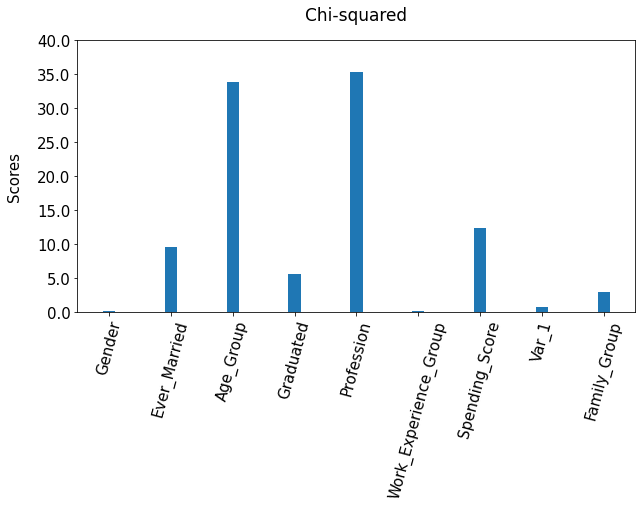

In [19]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)

fig, ax = plt.subplots(1,1,figsize=(10,5))

position = np.arange(len(fs.scores_))
scores = np.around((fs.scores_/fs.scores_.sum())*100,2)

ax.bar(position, scores, width=0.2)

ax.set_xticks(position)
ax.set_xticklabels(X.columns,fontsize=15, rotation=75)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(np.around(ax.get_yticks(),2), fontsize=15)
ax.set_ylabel("Scores", labelpad=15, fontsize=15)

ax.set_title("Chi-squared", y=1.05, fontsize=17);

- #### Using as score function the Mutual info

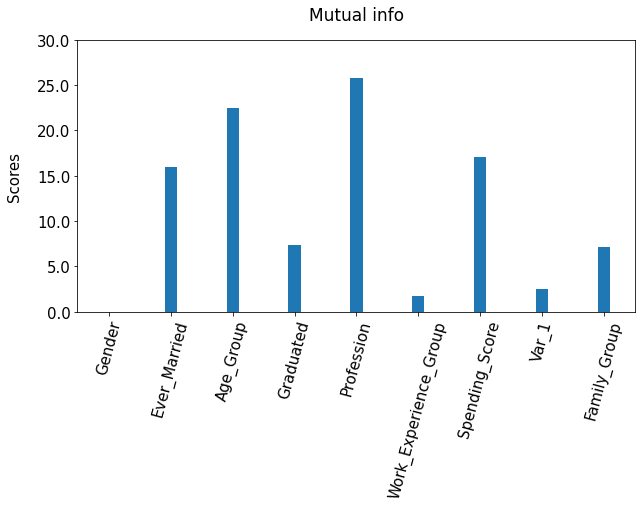

In [20]:
fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(X_train, y_train)

fig, ax = plt.subplots(1,1,figsize=(10,5))

position = np.arange(len(fs.scores_))
scores = np.around((fs.scores_/fs.scores_.sum())*100,2)

ax.bar(position, scores, width=0.2)

ax.set_xticks(position)
ax.set_xticklabels(X.columns,fontsize=15, rotation=75)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(np.around(ax.get_yticks(),2), fontsize=15)
ax.set_ylabel("Scores", labelpad=15, fontsize=15)

ax.set_title("Mutual info", y=1.05, fontsize=17);

Write here what do I understand...and where do I conclude!!...use of 4 highest features to try and understand the segments! Take the four features with the highest score.

In [21]:
fs = SelectKBest(score_func=chi2, k=4)
fs.fit(X_train, y_train)

pos = sorted(fs.scores_)[-4:]
which_features_index = []
for x in pos:
    which_features_index.append(np.argwhere(x==fs.scores_)[0,0])
which_features_index.append(9)
    
which_features_names = []
for x in which_features_index:
    which_features_names.append(data_cl.columns[x])

data = data_cl[which_features_names]

I apply directly an **<ins>inverse transform</ins>** in order to continue with the data analysis.

In [22]:
inverse_transformation = []
for x in which_features_index:
    inverse_transformation.append(for_decoding[x])
    
for col, trans in zip(data,inverse_transformation):
    data[col] = trans.inverse_transform(data[col])
    
data.head()

<ipython-input-22-fa4b79812048>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = trans.inverse_transform(data[col])


Ever_Married Spending_Score          Age_Group  Profession Segmentation
0           No            Low              Young  Healthcare            D
1          Yes            Low         Middle age    Engineer            B
2          Yes           High         Middle age      Lawyer            B
3          Yes        Average         Middle age      Artist            C
4           No            Low  Older millennials  Healthcare            C

### Define functions for stacked barplots

I will define two functions for doing data analysis with proportion statistics. The functions will create stacked barplots. The one combines three features and the other two, and both give back the stacked barplots. The stacked bars will show either a combination of the first two variables or only the first variable as percentage of the other variable. On top of the bar plots will be shown the percentage of the last given variable in the dataset.

In [23]:
##############################################################################################################
#####################   function which will be giving a stacked barplot for 3 features #######################
##############################################################################################################
def stacked_barplots_3_variables(df, variables, axes):
    conn_var_a_b = df.groupby(variables).size().unstack()
    conn_var_a_b = round((conn_var_a_b/conn_var_a_b.sum()),2).T

    perc_c = round((df[variables[2]].value_counts()/df[variables[2]].value_counts().sum())*100,2).sort_values().tolist()

    conn_var_a_b.plot(ax=axes, kind='bar', width=0.2, stacked = True)

    for_x_axis = df[variables[2]].value_counts().sort_values()
    x_ticks = np.arange(len(for_x_axis.keys())) 
    x_ticklabels = dict(for_x_axis).keys()
    axes.set_xticks(x_ticks)
    axes.set_xticklabels(x_ticklabels, fontsize=15, rotation=25)

    y_ticks, y_ticklabels = [0.25,0.5,0.75,1], [25,50,75,100]
    axes.set_yticks(y_ticks)
    axes.set_yticklabels(y_ticklabels, fontsize=15)
    axes.set_ylim(0,1.5)

    axes.legend(loc='upper center', fontsize=15)
    
    for p in axes.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if height!=0:
            axes.text(x+width/2, y+height/2, '{:.1f}%'.format(height*100), 
                    horizontalalignment='center', verticalalignment='center',fontsize=14)

    for count, value in enumerate(perc_c):
        axes.text(count, 1.04, '{:.1f}%'.format(value), 
                  horizontalalignment='center', 
                  verticalalignment='center',
                  fontsize=22)
        
        
##############################################################################################################
#####################   function which will be giving a stacked barplot for 2 features #######################
##############################################################################################################
def stacked_barplots_2_variables(df, variables, axes):
    conn_var = df.groupby(variables).size().unstack()
    conn_var = round((conn_var/conn_var.sum()),2).T

    perc_b = round((df[variables[1]].value_counts()/df[variables[1]].value_counts().sum())*100,2).sort_values().tolist()

    conn_var.plot(ax=axes, kind='bar', width=0.2, stacked=True)
    
    for_x_axis = df[variables[1]].value_counts().sort_values()
    x_ticks = np.arange(len(for_x_axis.keys())) 
    x_ticklabels = dict(for_x_axis).keys()
    axes.set_xticks(x_ticks)
    axes.set_xticklabels(x_ticklabels, fontsize=15, rotation=25)

    y_ticks, y_ticklabels = [0.25,0.5,0.75,1], [25,50,75,100]
    axes.set_yticks(y_ticks)
    axes.set_yticklabels(y_ticklabels, fontsize=15)
    axes.set_ylim(0,1.5)

    axes.legend(loc='upper center', fontsize=15)
    
    for p in axes.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if height!=0 and height>=0.1:
            axes.text(x+width/2, y+height/2, '{:.1f}%'.format(height*100), 
                    horizontalalignment='center', verticalalignment='center',fontsize=18)

    for count, value in enumerate(perc_b):
        axes.text(count, 1.04, '{:.1f}%'.format(value), 
                  horizontalalignment='center', 
                  verticalalignment='center',
                  fontsize=22)

Let's do it for other variables -> Ever_Married - Spending_Score - Segmentation

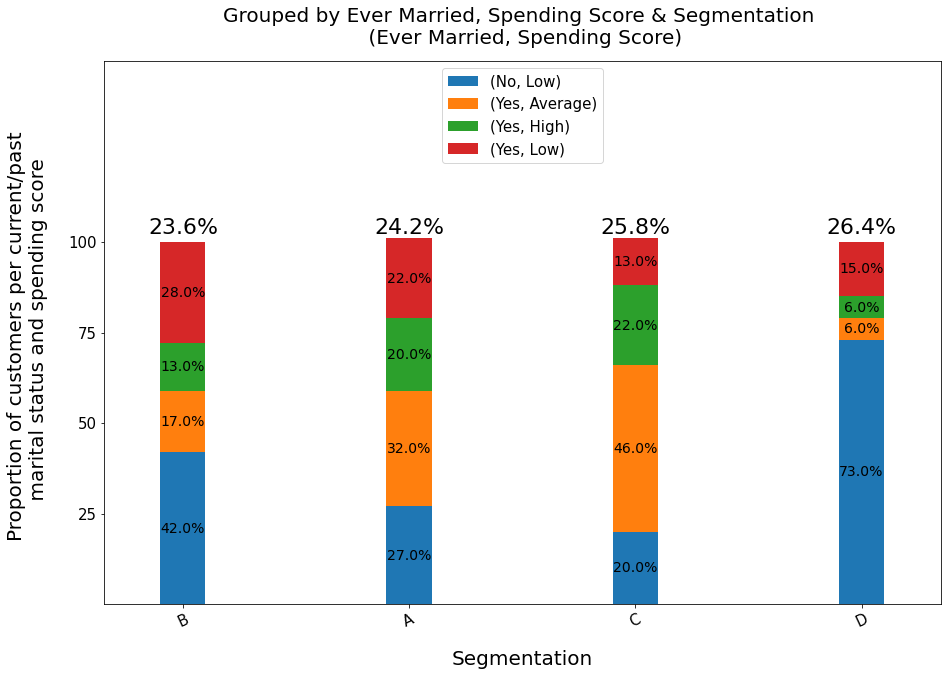

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

ax.set_title('Grouped by Ever Married, Spending Score & Segmentation \n (Ever Married, Spending Score)', 
             y=1.02, fontsize = 20)
ax.set_xlabel('Segmentation', labelpad = 20, fontsize = 20)
ax.set_ylabel('Proportion of customers per current/past \n marital status and spending score', labelpad = 20, fontsize = 20)

stacked_barplots_3_variables(data, ['Ever_Married', 'Spending_Score', 'Segmentation'], ax)

Here one can see that:
- Segment D consists of customers who spend low and have never been married
- one can also understand that the cases (No, Average) & (No, High) are missing as options from the dataset..! this means that there are no customers who have high or average spending_score and have never been married.

Let's give an eye for the case of Profession and Segmentation. Here, I use the function which takes two variables.

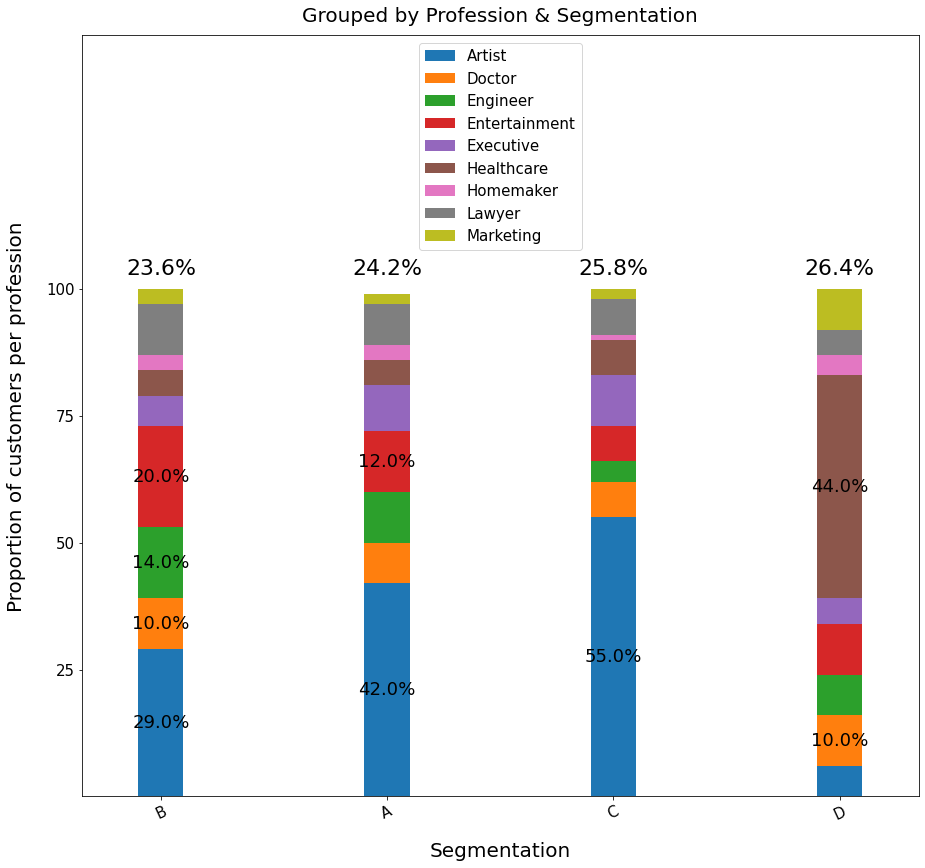

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15,14))

ax.set_title('Grouped by Profession & Segmentation', 
             y=1.01, fontsize = 20)
ax.set_xlabel('Segmentation', labelpad = 20, fontsize = 20)
ax.set_ylabel('Proportion of customers per profession', labelpad = 20, fontsize = 20)

stacked_barplots_2_variables(data, ['Profession','Segmentation'], ax)

The profession artist shares the highest percentage in the whole dataset at all. Segments A-C are not really clear, whereas to segment D belong mainly customers whose profession is healthcare and doctor.

In the next step I check the Age group in each segment.

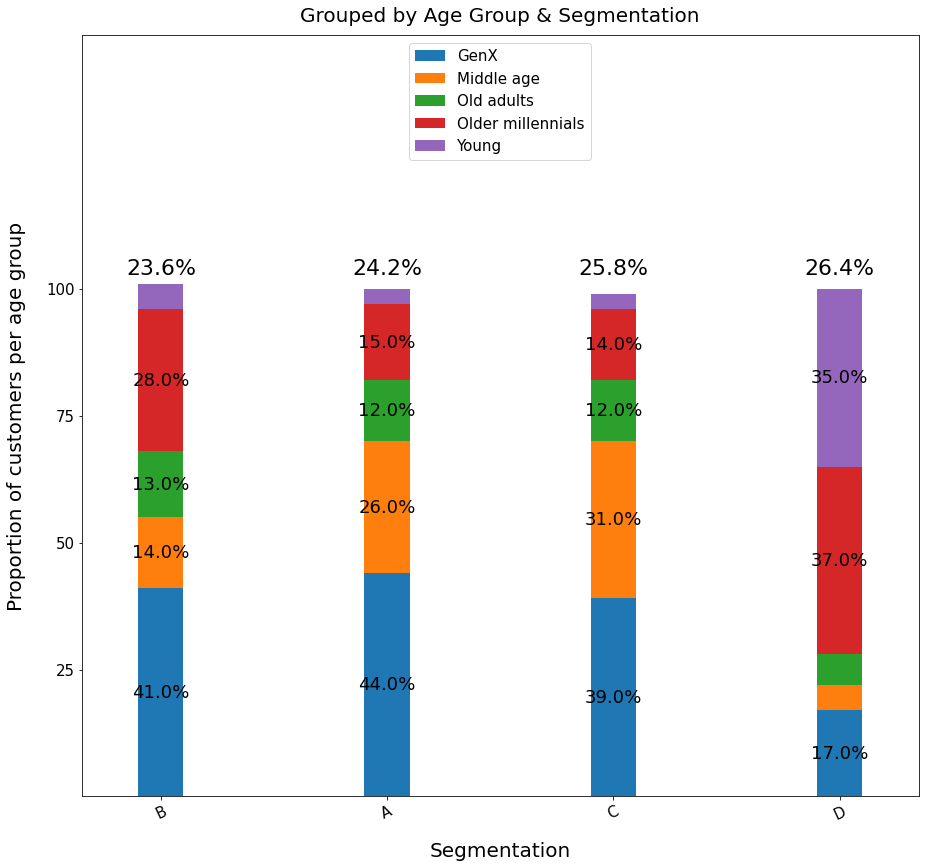

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15,14))

ax.set_title('Grouped by Age Group & Segmentation', 
             y=1.01, fontsize = 20)
ax.set_xlabel('Segmentation', labelpad = 20, fontsize = 20)
ax.set_ylabel('Proportion of customers per age group', labelpad = 20, fontsize = 20)

stacked_barplots_2_variables(data, ['Age_Group','Segmentation'], ax)

- Segments A & C are mainly occupied by customers with an age between 36 - 67
- In Segment B there are customers between 26 - 50 years old (41% + 28%)
- In Segment D it is absolutely clear that the customers are young, between 18 - 35 years old (> 70%).

In the last plot, I will see the combination of Age group and ever married for each segment.

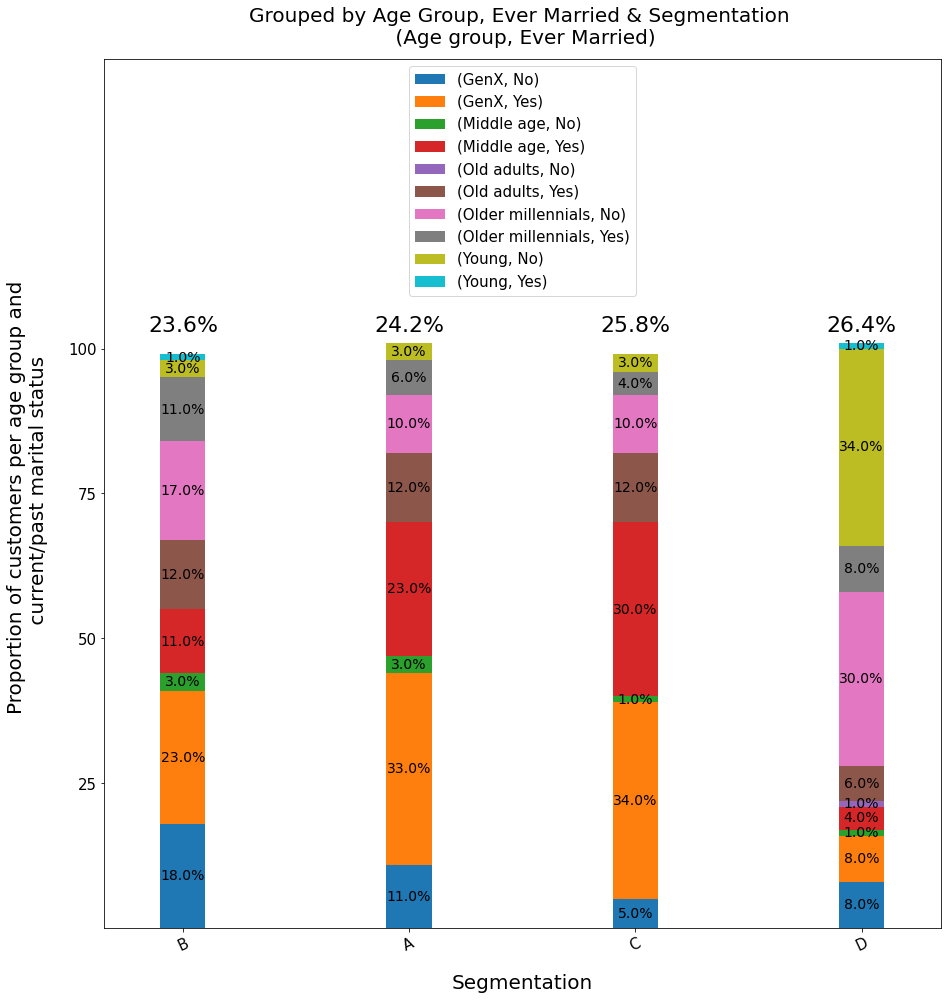

In [27]:
fig, ax = plt.subplots(1,1,figsize=(15,16))

ax.set_title('Grouped by Age Group, Ever Married & Segmentation \n (Age group, Ever Married)', 
             y=1.01, fontsize = 20)
ax.set_xlabel('Segmentation', labelpad = 20, fontsize = 20)
ax.set_ylabel('Proportion of customers per age group and \n current/past marital status', labelpad = 20, fontsize = 20)

stacked_barplots_3_variables(data, ['Age_Group','Ever_Married','Segmentation'], ax)

- Segment D has principally customers who have never been married and are up to 25 years old
- Segments B & C have customers who are in the range of 35 - 67 and have been married

So, how have the segments been formed initially?

Only <u>**segment D**</u> is clear..it includes customer who mainly:
- are up to 25 years old and have never been married,
- spend low and
- declare employeed as doctors and in healthcare market.

Segment A & C have a big overlap. There are customers between 36 - 67 years old who have been married and customers are employeed as artists and in entertainment sector.

Segment B is not clear at all!

# Unsupervised Learning

It is time to use clustering to define new clusters. I will follow two approaches. For both cases, I wil continue with the selected best features that I have done the analysis above.

I start by encoding the data. Then,:

- <u>Approach 1</u>: I apply kmeans for several #cluster and select the optimal #clusters from the plot #clusters vs inertia. Then, I apply the optimal number of clusters on the dataset and I declare the new segments.

- <u>Approach 2</u>: I apply the Factor Analysis to decompose the data. Then, I find the optimal #clusters and declare the new segments.

After all this, I compare the final results (New Segments Aproach 1 vs New Segments Approach 2).

#### Apply LabelEncoder again on the data

In [28]:
for_decoding=[]
for col in data.columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    for_decoding.append(le)

<ipython-input-28-56584045519c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = le.fit_transform(data[col])


### Apply KMeans before Factor Analysis

Find the optimal number of clusters.

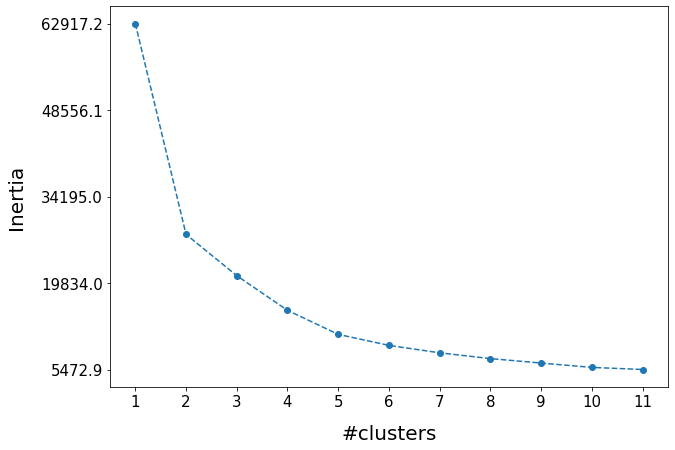

In [29]:
from sklearn.cluster import KMeans

number_of_clusters = [i for i in range(1,12)]
clusters_inertia = []
for cluster in number_of_clusters:
    km = KMeans(n_clusters=cluster,init="k-means++")
    km.fit(data.iloc[:,:-1])
    clusters_inertia.append(km.inertia_)

# plot #clusters vs inertia
fig, ax = plt.subplots(1,1,figsize=(10,7))

ax.plot(number_of_clusters, clusters_inertia, '--o')
ax.set_xticks(number_of_clusters)
ax.set_xticklabels(number_of_clusters, fontsize=15)

y_ticks = np.around(np.linspace(min(clusters_inertia),max(clusters_inertia),5),1)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=15)

ax.set_xlabel('#clusters', fontsize=20, labelpad=15)
ax.set_ylabel('Inertia', fontsize=20, labelpad=15);

The elbow method shows 5 clusters!! I apply the kmeans for 5 clusters and find the new segments and place them into a new column.

In [30]:
km = KMeans(n_clusters=5,init="k-means++")
km.fit(data.iloc[:,:-1])
data["New_Segments_without_FA"] = km.labels_ 
data.head(5)

<ipython-input-30-be1783b67540>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["New_Segments_without_FA"] = km.labels_


Ever_Married  Spending_Score  Age_Group  Profession  Segmentation  \
0             0               2          4           5             3   
1             1               2          1           2             1   
2             1               1          1           7             1   
3             1               0          1           0             2   
4             0               2          3           5             2   

   New_Segments_without_FA  
0                        1  
1                        0  
2                        4  
3                        2  
4                        1

### Apply FactorAnalysis and then KMeans

Apply the FactorAnalysis for a number fo components just 1 smaller than the original number of features, so 3 components.

In [31]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=3)
X_fa = fa.fit_transform(data.iloc[:,:-1])

data_fa = pd.DataFrame(X_fa, columns=["Component_%s" %i for i in range(1,4)])

Find the optimal number of clusters after applying the FactorAnalysis. 

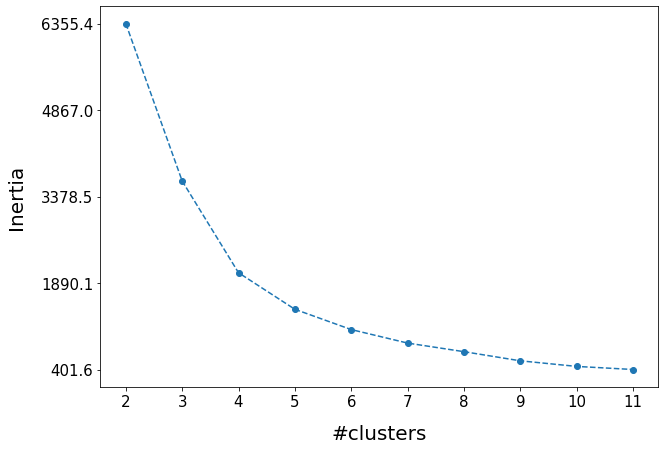

In [32]:
number_of_clusters = [i for i in range(2,12)]
clusters_inertia = []
for cluster in number_of_clusters:
    km = KMeans(n_clusters=cluster,init="k-means++")
    km.fit(data_fa.iloc[:,:-1])
    clusters_inertia.append(km.inertia_)

# plot #clusters vs inertia
fig, ax = plt.subplots(1,1,figsize=(10,7))

ax.plot(number_of_clusters, clusters_inertia, '--o')
ax.set_xticks(number_of_clusters)
ax.set_xticklabels(number_of_clusters, fontsize=15)

y_ticks = np.around(np.linspace(min(clusters_inertia),max(clusters_inertia),5),1)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=15)

ax.set_xlabel('#clusters', fontsize=20, labelpad=15)
ax.set_ylabel('Inertia', fontsize=20, labelpad=15);

The elbow method shows 4 clusters for this approach!! So, I apply the kmeans for 4 clusters and find the new segments and place them into a new column.

In [33]:
km = KMeans(n_clusters=4,init="k-means++")
km.fit(data_fa.iloc[:,:-1])
data_fa["New_Segments_with_FA"] = km.labels_ 

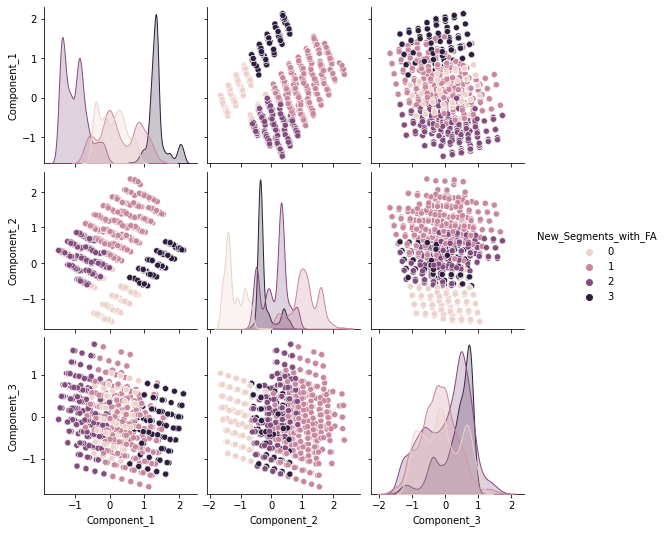

In [34]:
sns.pairplot(data=data_fa, hue='New_Segments_with_FA')

In [35]:
import plotly.express as px

fig = px.scatter_3d(data_fa, x='Component_1', y='Component_2', z='Component_3',
              color='New_Segments_with_FA', width=900, height=600)
fig.show()

In [36]:
data["New_Segments_with_FA"] = km.labels_
    
for col, trans in zip(data.columns[:-2],for_decoding):
    data[col] = trans.inverse_transform(data[col])
    

data['New_Segments_without_FA'] = data['New_Segments_without_FA'].replace({0:'A', 1:'B', 2:'C', 3:'D', 4:'E'})
data['New_Segments_with_FA'] = data['New_Segments_with_FA'].replace({0:'A', 1:'B', 2:'C', 3:'D'})

<ipython-input-36-82b17f3e3102>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-36-82b17f3e3102>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-36-82b17f3e3102>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-36-82b17f3

In [37]:
data

Ever_Married Spending_Score          Age_Group  Profession Segmentation  \
0              No            Low              Young  Healthcare            D   
1             Yes            Low         Middle age    Engineer            B   
2             Yes           High         Middle age      Lawyer            B   
3             Yes        Average         Middle age      Artist            C   
4              No            Low  Older millennials  Healthcare            C   
...           ...            ...                ...         ...          ...   
6660          Yes           High               GenX      Artist            B   
6661           No            Low  Older millennials   Executive            D   
6662           No            Low  Older millennials  Healthcare            D   
6663           No            Low  Older millennials  Healthcare            B   
6664          Yes        Average               GenX   Executive            B   

     New_Segments_without_FA New_Segments_with_FA  
0                          B                    D  
1                          A                    C  
2                          E                    B  
3                          C                    C  
4                          B                    D  
...                      ...                  ...  
6660                       C                    C  
6661                       B                    D  
6662                       B                    D  
6663                       B                    D  
6664                       A                    B  

[6665 rows x 7 columns]

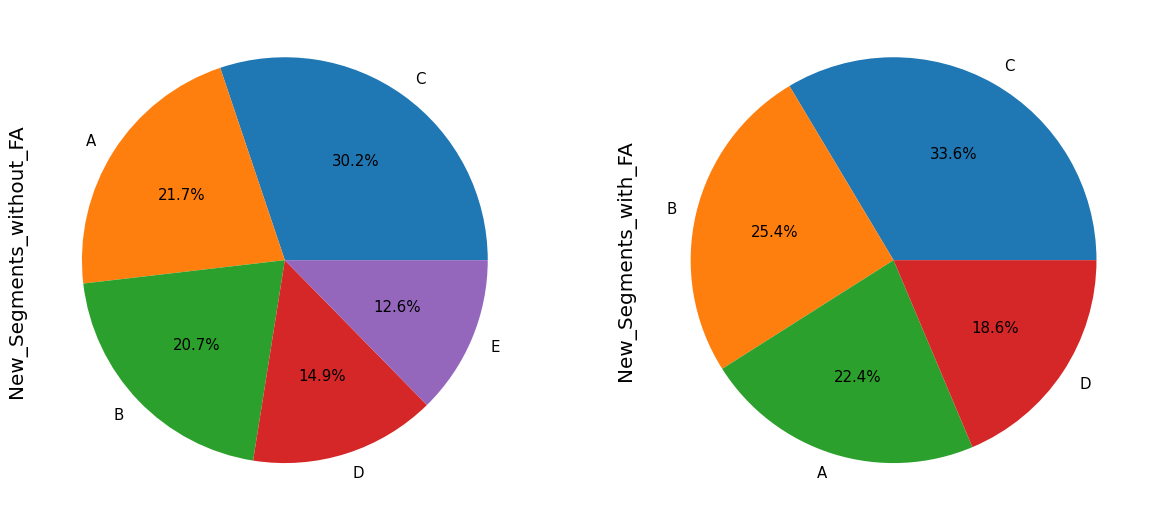

In [38]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

round((data["New_Segments_without_FA"].value_counts()/data["New_Segments_without_FA"].value_counts().sum())*100,2).plot.pie(autopct='%1.1f%%',
                                                                                                      ax=ax[0], 
                                                                                                      fontsize=15)
round((data["New_Segments_with_FA"].value_counts()/data["New_Segments_with_FA"].value_counts().sum())*100,2).plot.pie(autopct='%1.1f%%',
                                                                                                      ax=ax[1], 
                                                                                                      fontsize=15)

ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=20)
ax[1].set_ylabel(ax[1].get_ylabel(), fontsize=20);

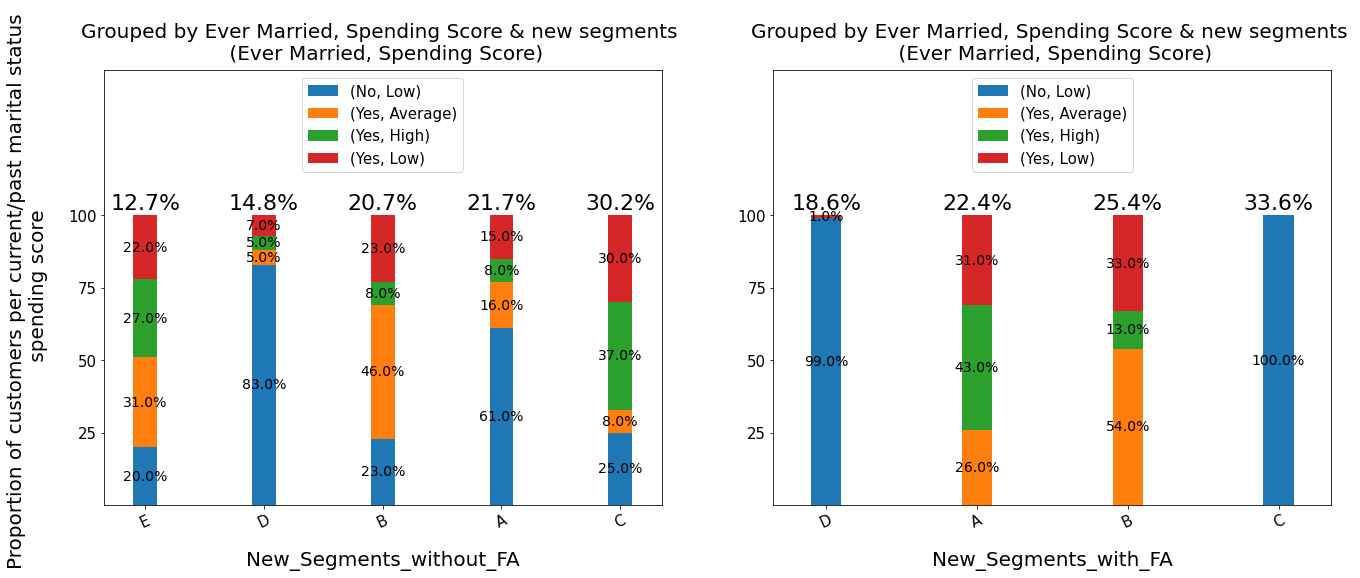

In [39]:
fig, ax = plt.subplots(1,2,figsize=(22,8))

ax[0].set_title('Grouped by Ever Married, Spending Score & new segments \n (Ever Married, Spending Score)', 
             y=1.01, fontsize = 20)
ax[0].set_xlabel('Segmentation', labelpad = 20, fontsize = 20)
ax[0].set_ylabel('Proportion of customers per current/past marital status \n spending score',
                 labelpad=20, fontsize=20)

stacked_barplots_3_variables(data, ['Ever_Married', 'Spending_Score','New_Segments_without_FA'], ax[0])
##############################################################################################################
##############################################################################################################
##############################################################################################################
ax[1].set_title('Grouped by Ever Married, Spending Score & new segments \n (Ever Married, Spending Score)', 
             y=1.01, fontsize = 20)
ax[1].set_xlabel('Segmentation', labelpad = 20, fontsize = 20)
ax[1].set_ylabel("")

stacked_barplots_3_variables(data, ['Ever_Married', 'Spending_Score','New_Segments_with_FA'], ax[1])

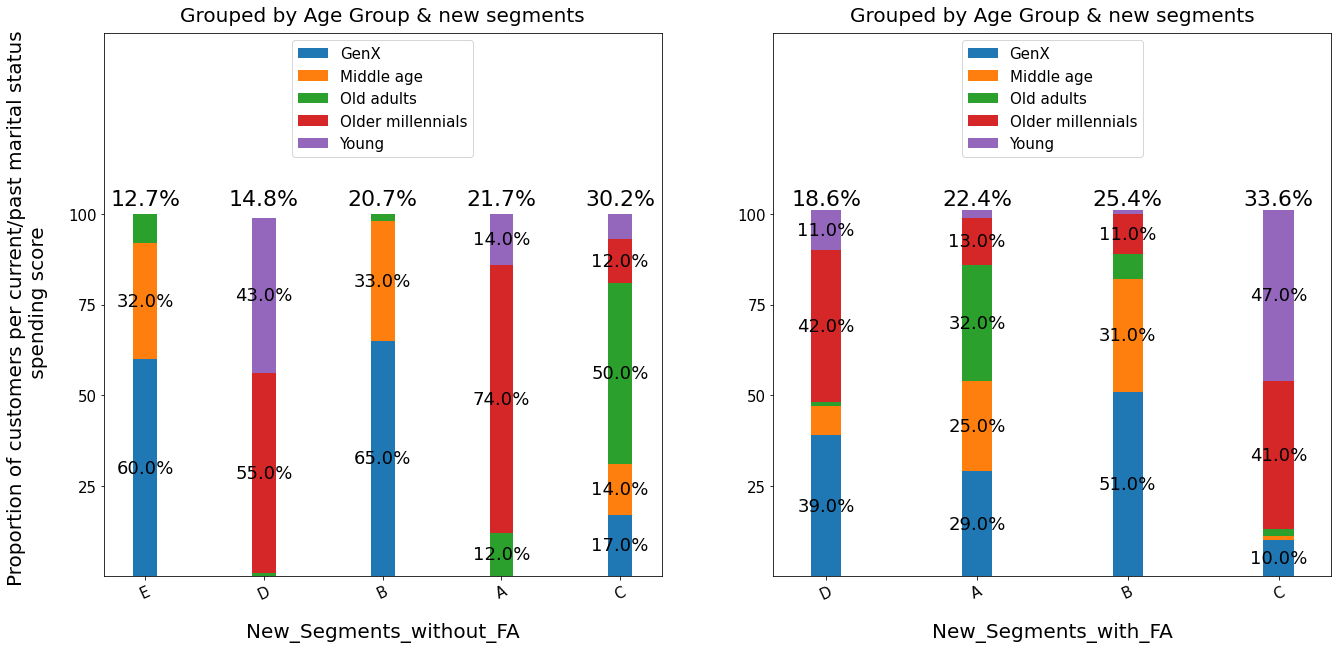

In [40]:
fig, ax = plt.subplots(1,2,figsize=(22,10))

ax[0].set_title('Grouped by Age Group & new segments', 
             y=1.01, fontsize = 20)
ax[0].set_xlabel('Segmentation', labelpad = 20, fontsize = 20)
ax[0].set_ylabel('Proportion of customers per current/past marital status \n spending score',
                 labelpad=20, fontsize=20)

stacked_barplots_2_variables(data, ['Age_Group','New_Segments_without_FA'], ax[0])
##############################################################################################################
##############################################################################################################
##############################################################################################################
ax[1].set_title('Grouped by Age Group & new segments', 
             y=1.01, fontsize = 20)
ax[1].set_xlabel('Segmentation', labelpad = 20, fontsize = 20)
ax[1].set_ylabel("")

stacked_barplots_2_variables(data, ['Age_Group','New_Segments_with_FA'], ax[1])

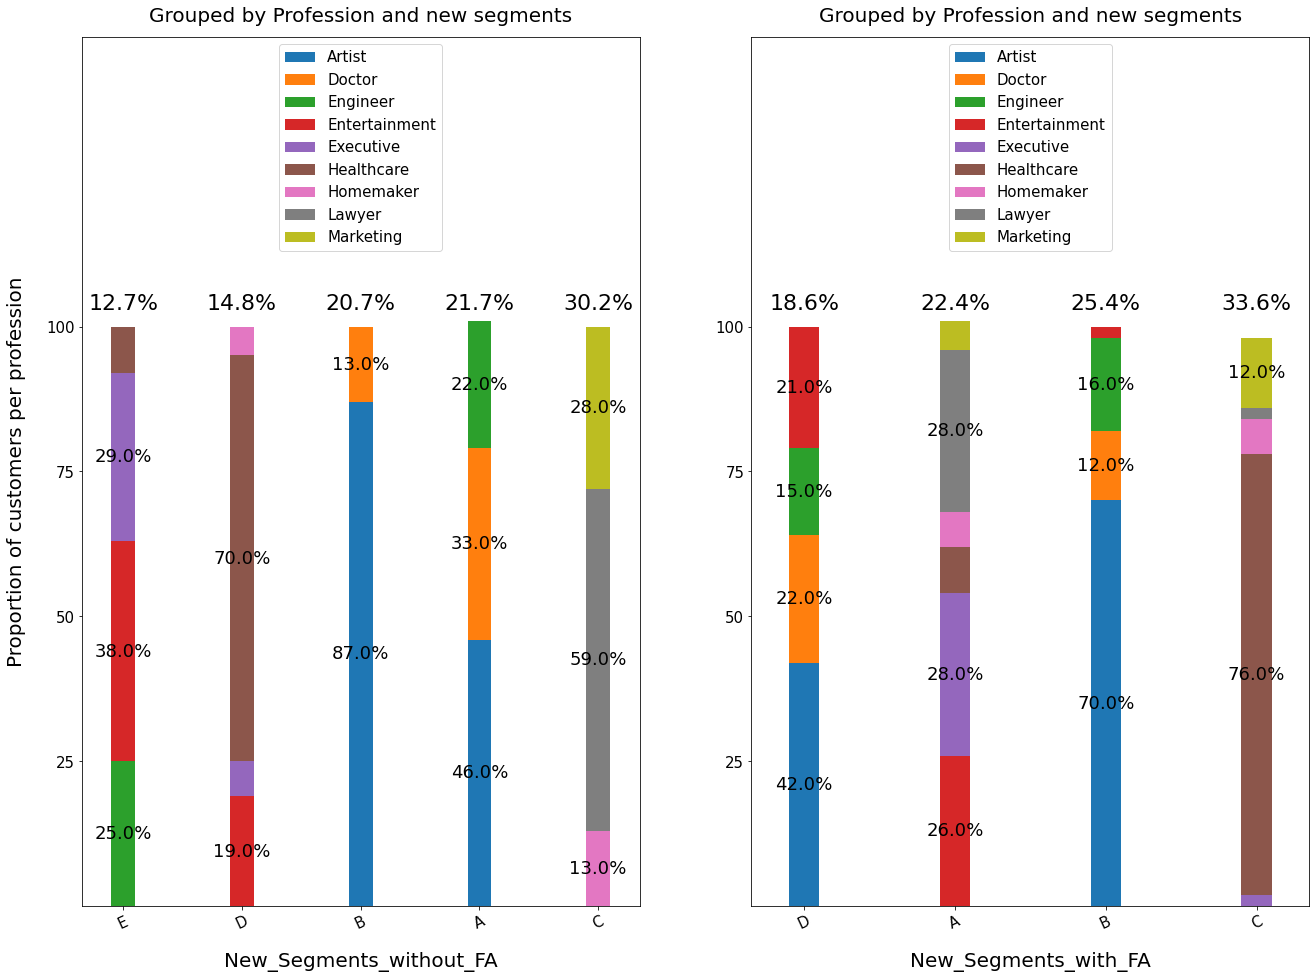

In [41]:
fig, ax = plt.subplots(1,2,figsize=(22,16))

ax[0].set_title('Grouped by Profession and new segments', 
             y=1.01, fontsize = 20)
ax[0].set_xlabel('Segmentation', labelpad = 20, fontsize = 20)
ax[0].set_ylabel('Proportion of customers per profession',
                 labelpad=20, fontsize=20)

stacked_barplots_2_variables(data, ['Profession','New_Segments_without_FA'], ax[0])
##############################################################################################################
##############################################################################################################
##############################################################################################################
ax[1].set_title('Grouped by Profession and new segments', 
             y=1.01, fontsize = 20)
ax[1].set_xlabel('Segmentation', labelpad = 20, fontsize = 20)
ax[1].set_ylabel("")

stacked_barplots_2_variables(data, ['Profession','New_Segments_with_FA'], ax[1])

At this stage I must comment out the new segments after applying the tw different approaches.


<u>**Approach A (kmeans -> 5 segments)**</u>:

- **Segment A (30.2%)**:
    - The customers are spending <u>low</u> and have <u>never been married</u>. They are <u>up to 35 years old</u> and are working in the <u>healthcare</u> sector.
- **Segment B (21.7%)**: 
    - The customers are between 26 - 35 years old (Older millennials).
- **Segment C (12.6%)**: 
    - The customers are mainly artists.
- **Segment D (14.9%)**: 
    - Not clear!
- **Segment E (20.7%)**: 
    - Customers are mainly laywers and 50% of this segment are over 67 years old.


<u>**Approach B (FactorAnalysis + kmeans -> 4 segments)**</u>:

- **Segment A (22.1%)**:
    - The customers are spending between <u>average and low</u> and they have <u>been married</u>. <u>32%</u> of this segment has customers <u>over 67 years old</u> and about <u>56% are lawyers and executives</u>.
- **Segment B (25.4%)**:
    - The customers are spending between <u>average and low</u> and they have <u> been married</u>. The majority are artists and they are between <u>35 - 67 years old</u>.
- **Segment C (33.6%)**:
    - The customers are spending <u>low</u> and they have <u>never been married</u>. They are mainly working in the <u>Healthcare</u> sector of the market and are <u>up to 35 years old</u>.
- **Segment D (18.9%)**:
    - The customers are spending <u>low</u> and have <u>never been married</u> (except of 1% who has!!). The age of the customers ranges between 25 and 50 years old.

Are there similarities between the new segments of the two approaches?

Yes! 
- Segment A of Approach A is very close to Segment C of approach B,
- Segment E of Approach A is quite similar to segment A of Approach B. 

## Appendix

In the case of kaggle, one has to apply the result on the test.csv and submit a version of csv file, where you have the customer ID with the segment.

In [43]:
test = pd.read_csv("Test.csv")
test

ID  Gender Ever_Married  Age Graduated     Profession  \
0     458989  Female          Yes   36       Yes       Engineer   
1     458994    Male          Yes   37       Yes     Healthcare   
2     458996  Female          Yes   69        No            NaN   
3     459000    Male          Yes   59        No      Executive   
4     459001  Female           No   19        No      Marketing   
...      ...     ...          ...  ...       ...            ...   
2622  467954    Male           No   29        No     Healthcare   
2623  467958  Female           No   35       Yes         Doctor   
2624  467960  Female           No   53       Yes  Entertainment   
2625  467961    Male          Yes   47       Yes      Executive   
2626  467968  Female           No   43       Yes     Healthcare   

      Work_Experience Spending_Score  Family_Size  Var_1  
0                 0.0            Low          1.0  Cat_6  
1                 8.0        Average          4.0  Cat_6  
2                 0.0            Low          1.0  Cat_6  
3                11.0           High          2.0  Cat_6  
4                 NaN            Low          4.0  Cat_6  
...               ...            ...          ...    ...  
2622              9.0            Low          4.0  Cat_6  
2623              1.0            Low          1.0  Cat_6  
2624              NaN            Low          2.0  Cat_6  
2625              1.0           High          5.0  Cat_4  
2626              9.0            Low          3.0  Cat_7  

[2627 rows x 10 columns]

The problem with my analysis above is that I did not use any imputer method to replace the Nan values. If I had done it, I could apply the result of the "imputer part" on the test dataset and then I would apply the Approach B and submit the sample_submission.csv file which includes the customer ID and the segment.